In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
from sqlalchemy import create_engine
import time
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler, FunctionTransformer
from scipy.stats import boxcox
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit


In [2]:
con = pymysql.connect(host='localhost', user='jiwoo', password='1234', db='TESTDB', charset='utf8', autocommit=True, cursorclass=pymysql.cursors.DictCursor)
cur = con.cursor()
sql = "SELECT pk, 시도, 시군구, complex_name, official_price, 경도, 위도, closest_sub, closest_high, school_1km, area, floor, actual FROM off_act_price WHERE 시도='서울특별시'"
cur.execute(sql)
rows = cur.fetchall()
con.close()

In [3]:
gangwon = pd.DataFrame(rows)

real_trainInfo = gangwon.dropna(subset='actual')
needPredict = gangwon[gangwon['actual'].isnull()==True]

X = real_trainInfo.drop('actual', axis=1)
y = real_trainInfo['actual']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [22]:
gangwon

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual
0,00001553_0001_0001,서울특별시,강동구,대우,438000000.0,127.043878,37.04594,1.416850,0.839742,1.0,22.0,1.0,NaN
1,00001553_0001_0001,서울특별시,강동구,대우,438000000.0,127.043878,37.04594,1.416850,0.839742,1.0,22.0,1.0,NaN
2,00001553_0001_0002,서울특별시,강동구,대우,438000000.0,127.043878,37.04594,1.416850,0.839742,1.0,22.0,1.0,NaN
3,00001553_0001_0002,서울특별시,강동구,대우,438000000.0,127.043878,37.04594,1.416850,0.839742,1.0,22.0,1.0,NaN
4,00001553_0001_0003,서울특별시,강동구,대우,438000000.0,127.043878,37.04594,1.416850,0.839742,1.0,22.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6610704,20410619_0001_0006,서울특별시,중랑구,탑클래스2차,249000000.0,127.087847,37.59927,0.339496,0.421766,12.0,13.0,6.0,NaN
6610705,20410619_0001_0007,서울특별시,중랑구,탑클래스2차,225000000.0,127.087847,37.59927,0.339496,0.421766,12.0,12.0,7.0,NaN
6610706,20410619_0001_0008,서울특별시,중랑구,탑클래스2차,249000000.0,127.087847,37.59927,0.339496,0.421766,12.0,13.0,7.0,NaN
6610707,20410619_0001_0009,서울특별시,중랑구,탑클래스2차,185000000.0,127.087847,37.59927,0.339496,0.421766,12.0,9.0,8.0,NaN


In [4]:
train_pk = x_train[['pk', 'complex_name', '시군구']]
valid_pk = x_valid[['pk', 'complex_name', '시군구']]
test_pk = X_test[['pk', 'complex_name', '시군구']]
predict_pk = needPredict[['pk', 'complex_name', '시군구']]

train_data = x_train.join(y_train)
train_data['floor'] = train_data['floor']+2
needPredict['floor'] = needPredict['floor']+2
#train_data['1km내sub수+'] = train_data['1km내sub수']+2
train_data['school_1km'] = train_data['school_1km']+2
needPredict['school_1km'] = needPredict['school_1km']+2

from scipy.stats import boxcox
#train_data['area'] = train_data['area'].apply(lambda x: boxcox(x)[0])
train_data[['school_1km', 'area']] = np.sqrt(train_data[['school_1km', 'area']])
train_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(train_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])
#needPredict['area'] = needPredict['area'].apply(lambda x: boxcox(x)[0])
needPredict[['school_1km', 'area']] = np.sqrt(needPredict[['school_1km', 'area']])
needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(needPredict[['floor', 'official_price', 'closest_sub', 'closest_high']])

realX = needPredict.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1)

x_train, y_train = train_data.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1), train_data['actual']

valid_data = x_valid.join(y_valid)

valid_data['floor'] = valid_data['floor']+2
#valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
valid_data['school_1km'] = valid_data['school_1km']+2

valid_data[['school_1km', 'area']] = np.sqrt(valid_data[['school_1km', 'area']])
valid_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(valid_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])

x_valid, y_valid = valid_data.drop(['actual', 'pk', '시도', 'complex_name', '시군구'], axis=1), valid_data['actual']

test_data = X_test.join(y_test)

test_data['floor'] = test_data['floor']+2
#valid_data['1km내sub수+'] = valid_data['1km내sub수']+2
test_data['school_1km'] = test_data['school_1km']+2

#valid_data['area'] = valid_data['area'].apply(lambda x: boxcox(x)[0])
test_data[['school_1km', 'area']] = np.sqrt(test_data[['school_1km', 'area']])
test_data[['actual_price','floor', 'official_price', 'closest_sub', 'closest_high']] = np.log(test_data[['actual','floor', 'official_price', 'closest_sub', 'closest_high']])

y_test_actual_price = test_data['actual']
X_test, y_test = test_data.drop(['actual', 'actual_price', 'pk', '시도', 'complex_name', '시군구'], axis=1), test_data['actual_price']

<ipython-input-4-4dd4d96adb15>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict['floor'] = needPredict['floor']+2
<ipython-input-4-4dd4d96adb15>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  needPredict['school_1km'] = needPredict['school_1km']+2
<ipython-input-4-4dd4d96adb15>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [5]:
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_valid_s = scaler.transform(x_valid)
X_test_s = scaler.transform(X_test)

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

tree = DecisionTreeRegressor()
tree.fit(x_train_s, y_train)

treeScore = tree.score(X_test_s, y_test)

y_pred_train = tree.predict(x_train_s)

tree_R2 = r2_score(y_train, y_pred_train)
tree_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_valid = tree.predict(x_valid_s)

tree_R2 = r2_score(y_valid, y_pred_valid)
tree_mae = mean_absolute_error(y_valid, y_pred_valid)

from sklearn.model_selection import cross_val_score
tree_scores = cross_val_score(tree, x_valid_s, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

final_pred_tree = tree.predict(X_test_s)

from sklearn.metrics import mean_squared_error
final_mse_tree = mean_squared_error(y_test, final_pred_tree)
final_rmse_tree = np.sqrt(final_mse_tree)
final_r2_tree = r2_score(y_test, final_pred_tree)

needPredict_s = scaler.transform(realX)
finalPred = tree.predict(needPredict_s)
needPred_df = pd.DataFrame(finalPred, columns=['예측가격'])
needPred_df[['pk', 'complex_name', '시군구']] = predict_pk[['pk', 'complex_name', '시군구']].values
needPred_df['predicted_price'] = np.exp(needPred_df['예측가격'])
needPred_df.drop('예측가격', axis=1, inplace=True)

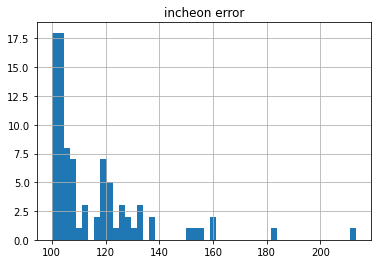

In [7]:
# 예측값
pred_tr = pd.DataFrame(final_pred_tree, columns=['예측가격'])
pred_tr[['pk', 'complex_name', '시군구']] = test_pk[['pk', 'complex_name', '시군구']].values
pred_tr['predicted_price'] = np.exp(pred_tr['예측가격'])
pred_tr['actual_price'] = y_test_actual_price.values
pred_tr['predicted_price'] = pred_tr['predicted_price'].astype(float)
# 결측치가 있는 것 같지는 않고 nan 이런 식으로 숫자가 아닌 데이터가 있는 듯. 확인해보기 바람
pred_tr.drop('예측가격', axis=1, inplace=True)
#pred_tr['predicted_price'] = pred_tr['predicted_price'].apply(lambda x: '{:.0f}'.format(x))
#jisang['codes'] = jisang['호str'].apply(lambda x: int(x) if x.isnumeric() else 0)

pred_tr['error'] = (pred_tr['predicted_price'] - pred_tr['actual_price']) / pred_tr['actual_price'] * 100

In [ ]:
check = pred_tr[(pred_tr['error']>100)]

check['error'].hist(bins=50)
plt.rc("axes", unicode_minus=False)
plt.rc('font', family='NanumGothic')
plt.title('incheon error')
plt.show()

In [9]:
pred_tr.describe()

,predicted_price,actual_price,error
count,9.921320e+05,9.921320e+05,992132.000000
mean,8.468253e+08,8.589842e+08,1.759841
std,5.532108e+08,5.772220e+08,18.812741
min,7.248032e+07,6.000000e+07,-67.500000
25%,4.591580e+08,4.500000e+08,-10.337550
50%,6.761903e+08,6.920000e+08,0.857032
75%,1.046900e+09,1.090000e+09,13.451833
max,9.450000e+09,1.100000e+10,213.333333


In [10]:
check.describe()

,predicted_price,actual_price,error
count,8.800000e+01,8.800000e+01,88.000000
mean,1.074843e+09,4.987573e+08,115.195417
std,1.163786e+09,5.341271e+08,19.494224
min,1.800000e+08,6.000000e+07,100.000000
25%,5.485805e+08,2.500000e+08,102.777123
50%,7.305876e+08,3.517500e+08,107.253182
75%,1.140000e+09,5.050000e+08,120.661047
max,9.450000e+09,4.450000e+09,213.333333


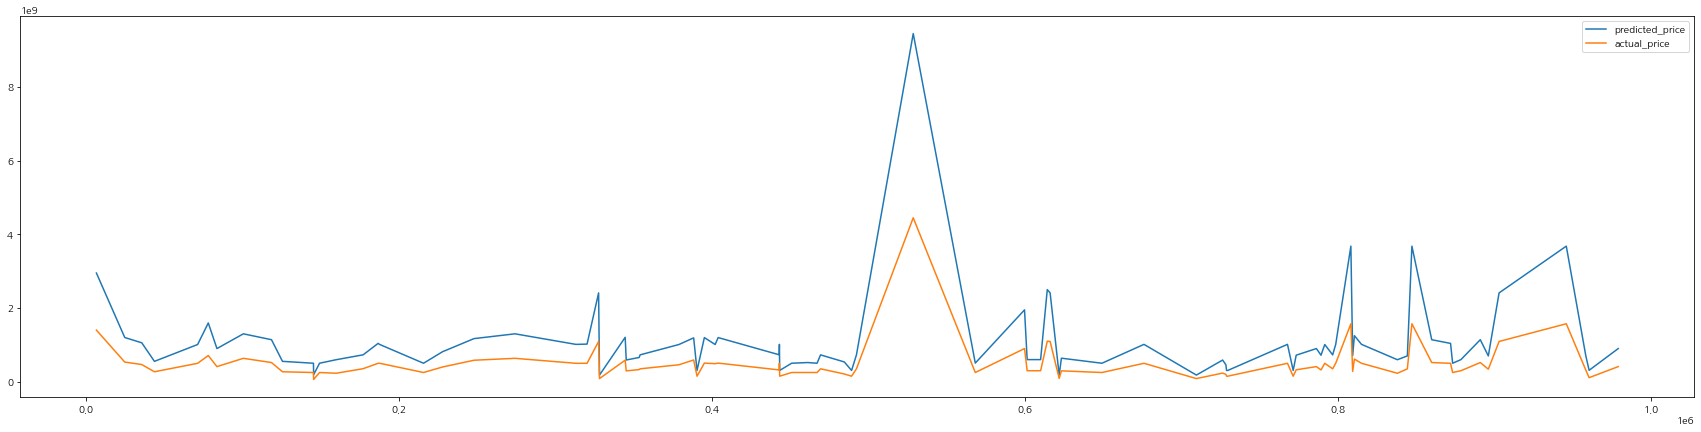

In [11]:
test_df = pred_tr[['pk', 'predicted_price']]
total_df = pd.concat([needPred_df, test_df])


final_tr = check[['predicted_price', 'actual_price']]

final_tr.iloc[0:100, :].plot(figsize=(30,7))
plt.show()


In [13]:
pd.set_option('display.max_rows', None)
check

,pk,complex_name,시군구,predicted_price,actual_price,error
6905,00001488_0001_0174,대림아크로빌,강남구,2.950000e+09,1.400000e+09,110.714286
25005,00050614_0001_0026,예성2차그린캐슬,관악구,1.200000e+09,5.330000e+08,125.140713
35864,20321013_0001_0130,엘에이치강남힐스테이트,강남구,1.056455e+09,4.664000e+08,126.512612
43975,00050302_0002_0130,상아2차아파트,도봉구,5.526189e+08,2.700000e+08,104.673679
71562,00000123_0035_0033,남산타운,중구,1.009869e+09,5.000000e+08,101.973865
78375,00248841_0003_0042,경남아너스빌,양천구,1.595000e+09,7.100000e+08,124.647887
83899,00000159_0012_0022,전농우성,동대문구,9.000000e+08,4.100000e+08,119.512195
100776,20277694_0002_0008,프레미어스엠코,중랑구,1.300000e+09,6.350000e+08,104.724409
118758,00000249_0004_0064,극동그린,성동구,1.140000e+09,5.200000e+08,119.230769
125762,00050302_0002_0134,상아2차아파트,도봉구,5.526189e+08,2.700000e+08,104.673679


In [16]:
check_small = pred_tr[(pred_tr['error']>-5)&(pred_tr['error']<5)]
check_small.describe()
# 오차율 5프로 이내 약 25만개

,predicted_price,actual_price,error
count,2.520430e+05,2.520430e+05,2.520430e+05
mean,9.201358e+08,9.202516e+08,7.905332e-02
std,6.213900e+08,6.221630e+08,2.579751e+00
min,7.305673e+07,7.000000e+07,-5.000000e+00
25%,4.748446e+08,4.750000e+08,-1.774180e+00
50%,7.354026e+08,7.380000e+08,3.243790e-14
75%,1.216184e+09,1.220000e+09,2.018226e+00
max,9.450000e+09,9.450000e+09,5.000000e+00


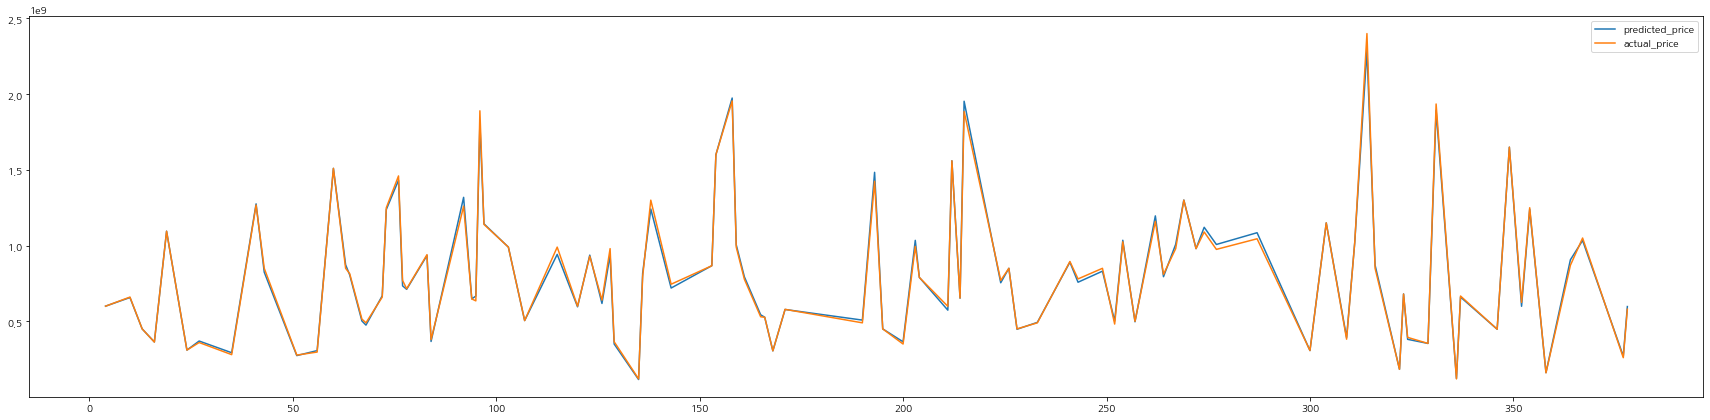

In [17]:
test_df = pred_tr[['pk', 'predicted_price']]
total_df = pd.concat([needPred_df, test_df])


final_tr = check_small[['predicted_price', 'actual_price']]

final_tr.iloc[0:100, :].plot(figsize=(30,7))
plt.show()

In [18]:
check_small

,pk,complex_name,시군구,predicted_price,actual_price,error
4,20293273_0002_0075,신내우디안1단지,중랑구,6.000000e+08,6.000000e+08,1.192093e-13
10,00001900_0001_0004,벽산,강서구,6.570895e+08,6.600000e+08,-4.409780e-01
13,00000153_0003_0089,현대,동대문구,4.500000e+08,4.500000e+08,-1.324548e-13
16,00002574_0014_0058,중계무지개,노원구,3.637654e+08,3.630000e+08,2.108430e-01
19,00050199_0004_0081,현대3,영등포구,1.095000e+09,1.095000e+09,5.225613e-13
...,...,...,...,...,...,...
992119,00052571_0021_0027,등촌동아이파크,강서구,8.772067e+08,9.000000e+08,-2.532590e+00
992124,20099495_0031_0056,리센츠,송파구,1.854281e+09,1.880000e+09,-1.368024e+00
992125,00002287_0021_0013,올림픽훼밀리타운,송파구,1.750432e+09,1.670000e+09,4.816270e+00
992126,00001381_0019_0107,은마,강남구,2.035002e+09,1.990000e+09,2.261417e+00


In [19]:
check_small['complex_name'].value_counts()

은마           5301
잠실엘스         4578
주공아파트 5단지    4496
한신           4460
파크리오         3940
             ... 
청송아파트           1
은일로즈힐           1
성림(390-5)       1
흥인              1
NS파인트리          1
Name: complex_name, Length: 4378, dtype: int64

In [21]:
check_small[check_small['complex_name']=='은마']

,pk,complex_name,시군구,predicted_price,actual_price,error
477,00001381_0009_0169,은마,강남구,1.847765e+09,1.780000e+09,3.807039
496,00001381_0025_0067,은마,강남구,1.995459e+09,1.927000e+09,3.552642
497,00001381_0017_0001,은마,강남구,1.996403e+09,1.980000e+09,0.828449
642,00001381_0020_0022,은마,강남구,2.144479e+09,2.070000e+09,3.598011
700,00001381_0017_0007,은마,강남구,1.996403e+09,1.980000e+09,0.828449
...,...,...,...,...,...,...
991321,00001381_0021_0071,은마,강남구,1.804900e+09,1.770000e+09,1.971757
991538,00001381_0009_0063,은마,강남구,1.804715e+09,1.885000e+09,-4.259141
991709,00001381_0003_0093,은마,강남구,1.756993e+09,1.840000e+09,-4.511228
992109,00001381_0024_0150,은마,강남구,1.828470e+09,1.860000e+09,-1.695160


In [23]:
null = gangwon[gangwon['actual'].isnull()==True]

In [24]:
null[null['complex_name']=='은마']

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual


In [25]:
null[null['complex_name']=='잠실엘스']

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual
5326580,20107304_0004_0001,서울특별시,송파구,잠실엘스,2.332000e+09,127.083673,37.506967,0.45695,0.044109,11.0,36.0,10.0,NaN
5326581,20107304_0004_0002,서울특별시,송파구,잠실엘스,2.332000e+09,127.083673,37.506967,0.45695,0.044109,11.0,36.0,10.0,NaN
5326582,20107304_0004_0003,서울특별시,송파구,잠실엘스,2.169000e+09,127.083673,37.506967,0.45695,0.044109,11.0,36.0,1.0,NaN
5326583,20107304_0004_0004,서울특별시,송파구,잠실엘스,2.169000e+09,127.083673,37.506967,0.45695,0.044109,11.0,36.0,1.0,NaN
5326594,20107304_0004_0011,서울특별시,송파구,잠실엘스,2.383000e+09,127.083673,37.506967,0.45695,0.044109,11.0,36.0,14.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5382263,20107304_0058_0084,서울특별시,송파구,잠실엘스,1.885000e+09,127.083673,37.506967,0.45695,0.044109,11.0,26.0,29.0,NaN
5382264,20107304_0058_0085,서울특별시,송파구,잠실엘스,1.521000e+09,127.083673,37.506967,0.45695,0.044109,11.0,18.0,30.0,NaN
5382265,20107304_0058_0086,서울특별시,송파구,잠실엘스,1.521000e+09,127.083673,37.506967,0.45695,0.044109,11.0,18.0,30.0,NaN
5388522,20107304_0063_0085,서울특별시,송파구,잠실엘스,1.521000e+09,127.083673,37.506967,0.45695,0.044109,11.0,18.0,30.0,NaN


In [26]:
null[null['complex_name']=='주공아파트 5단지']

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual


In [27]:
null[null['complex_name']=='한신']

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual
1498777,20350403_0001_0001,서울특별시,관악구,한신,188000000.0,126.925691,37.476412,0.679122,0.130962,9.0,9.0,5.0,NaN
1498778,20350403_0001_0002,서울특별시,관악구,한신,188000000.0,126.925691,37.476412,0.679122,0.130962,9.0,9.0,6.0,NaN
1498779,20350403_0001_0003,서울특별시,관악구,한신,188000000.0,126.925691,37.476412,0.679122,0.130962,9.0,9.0,7.0,NaN
1498780,20350403_0001_0004,서울특별시,관악구,한신,188000000.0,126.925691,37.476412,0.679122,0.130962,9.0,9.0,8.0,NaN
1498781,20350403_0001_0005,서울특별시,관악구,한신,188000000.0,126.925691,37.476412,0.679122,0.130962,9.0,9.0,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442836,00002399_0010_0086,서울특별시,중랑구,한신,529000000.0,127.086487,37.584420,0.429538,0.104046,8.0,26.0,9.0,NaN
6442837,00002399_0010_0087,서울특별시,중랑구,한신,529000000.0,127.086487,37.584420,0.429538,0.104046,8.0,26.0,9.0,NaN
6442838,00002399_0010_0088,서울특별시,중랑구,한신,529000000.0,127.086487,37.584420,0.429538,0.104046,8.0,26.0,9.0,NaN
6442839,00002399_0010_0089,서울특별시,중랑구,한신,529000000.0,127.086487,37.584420,0.429538,0.104046,8.0,26.0,9.0,NaN


In [28]:
null[null['complex_name']=='파크리오']

,pk,시도,시군구,complex_name,official_price,경도,위도,closest_sub,closest_high,school_1km,area,floor,actual
5048144,20100792_0001_0153,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048145,20100792_0001_0154,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048146,20100792_0001_0155,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048147,20100792_0001_0156,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048148,20100792_0001_0157,서울특별시,송파구,파크리오,6.450000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5048797,20100792_0002_0182,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048798,20100792_0002_0183,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5048799,20100792_0002_0184,서울특별시,송파구,파크리오,6.590000e+08,127.104967,37.517302,0.295474,0.458851,7.0,11.0,9.0,NaN
5128548,20100792_0064_0083,서울특별시,송파구,파크리오,1.372000e+09,127.104967,37.517302,0.295474,0.458851,7.0,18.0,29.0,NaN
